# Project

In [52]:
import os
import yaml
import pytimeloop.timeloopfe.v4 as tl
from pytimeloop.timeloopfe.common.nodes import DictNode
from pytimeloop.timeloopfe.v4.art import Art
from pytimeloop.timeloopfe.v4.ert import Ert
import shutil
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def run_timeloop_mapper(architecture, problem, constraints, mapper, config, output_dir):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
        
    spec = tl.Specification.from_yaml_files(architecture, problem, constraints, mapper, jinja_parse_data=config)

    result = tl.accelergy_app(spec, output_dir=output_dir)
    shutil.copy(output_dir + "/ART.yaml", output_dir + "/timeloop-mapper.ART.yaml")
    shutil.copy(output_dir + "/ERT.yaml", output_dir + "/timeloop-mapper.ERT.yaml")

    spec.ERT = Ert(**DictNode.from_yaml_files(output_dir + "/ERT.yaml")["ERT"])
    spec.ART = Art(**DictNode.from_yaml_files(output_dir + "/ART.yaml")["ART"])

    spec.ERT['tables'][0]['actions'][0]['energy'] = 0.0
    spec.ERT['tables'][0]['actions'][1]['energy'] = 0.0
    spec.ERT['tables'][0]['actions'][2]['energy'] = 0.0
    spec.ERT['tables'][0]['actions'][3]['energy'] = 0.0

    return tl.call_mapper(spec, output_dir=output_dir)

In [3]:
def run_data_parallel(problem, num_gpus, pe_array_size):
    desc = f"DP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}"
    output_dir = f"./outputs/{desc}"
    
    result = run_timeloop_mapper(
        architecture='designs/system/arch.yaml',
        problem=problem,
        constraints='designs/system/constraints_dp.yaml',
        mapper='designs/_include/mapper.yaml',
        config={'gpu_meshX': num_gpus, 'pe_meshX': pe_array_size, 'pe_meshY': pe_array_size},
        output_dir=output_dir
    )

    print(desc, result.energy, result.cycles)
    
    return result

In [4]:
def run_tensor_parallel(problem, num_gpus, pe_array_size):
    desc = f"TP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}"
    output_dir = f"./outputs/{desc}"
    
    result = run_timeloop_mapper(
        architecture='designs/system/arch.yaml',
        problem=problem,
        constraints='designs/system/constraints_tp.yaml',
        mapper='designs/_include/mapper.yaml',
        config={'gpu_meshX': num_gpus, 'pe_meshX': pe_array_size, 'pe_meshY': pe_array_size},
        output_dir=output_dir
    )
    
    print(desc, result.energy, result.cycles)
    
    return result

In [5]:
LAYERS = [
    'layer_shapes/alexnet/0.yaml',
    'layer_shapes/alexnet/1.yaml',
    'layer_shapes/alexnet/2.yaml',
    'layer_shapes/alexnet/3.yaml',
    'layer_shapes/alexnet/4.yaml',
    'layer_shapes/alexnet/5.yaml',
    'layer_shapes/alexnet/6.yaml',
    'layer_shapes/alexnet/7.yaml'
]

NUM_GPUS = [16,]

PE_ARRAY_SIZES = [16,]

### Data-Parallel

In [6]:
def get_result_data_parallel(problem, num_gpus, pe_array_size):
    cache_path = f'cache/DP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}.pkl'
    try:
        result = pickle.load(open(cache_path, 'rb'))
        print(f"Loaded result from cache: {cache_path}")
        return result
    except:
        pass

    os.makedirs('outputs', exist_ok=True)
    os.makedirs('cache', exist_ok=True)
    
    r = run_data_parallel(problem, num_gpus, pe_array_size)
    r.clear_zero_energies()
    
    result = {
        'energy': r.energy,
        'per_component_energy': r.per_component_energy,
        'cycles': r.cycles
    }
    
    pickle.dump(result, open(cache_path, 'wb'))
    print(f"Saved result to cache: {cache_path}")
    return result

In [7]:
for num_gpus in NUM_GPUS:
    for pe_array_size in PE_ARRAY_SIZES:
        for problem in LAYERS:
            result = get_result_data_parallel(problem, num_gpus, pe_array_size)
            print(result)

Loaded result from cache: cache/DP_16GPU_16x16_Layer0.pkl
{'energy': 0.04088130765312, 'per_component_energy': {'MAC': 0.01473001728, 'RegisterFile': 0.003756536712192, 'LocalBuffer': 0.020363225659392, 'LocalMemory': 0.002031528001536}, 'cycles': 93702400}
Loaded result from cache: cache/DP_16GPU_16x16_Layer1.pkl
{'energy': 0.09149179192934401, 'per_component_energy': {'MAC': 0.04693966848, 'RegisterFile': 0.011983303213056, 'LocalBuffer': 0.015680429162496, 'LocalMemory': 0.016888391073792}, 'cycles': 13996800}
Loaded result from cache: cache/DP_16GPU_16x16_Layer2.pkl
{'energy': 0.045637688151244804, 'per_component_energy': {'MAC': 0.0235046043648, 'RegisterFile': 0.00602772887568384, 'LocalBuffer': 0.00417829330354176, 'LocalMemory': 0.0119270616072192}, 'cycles': 1752192}
Loaded result from cache: cache/DP_16GPU_16x16_Layer3.pkl
{'energy': 0.060738768470016, 'per_component_energy': {'MAC': 0.0313394724864, 'RegisterFile': 0.00803697183424512, 'LocalBuffer': 0.00557813902344192, 'Lo

### Tensor-Parallel

In [10]:
def get_result_tensor_parallel(problem, num_gpus, pe_array_size):
    cache_path = f'cache/TP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}.pkl'
    try:
        result = pickle.load(open(cache_path, 'rb'))
        print(f"Loaded result from cache: {cache_path}")
        return result
    except:
        pass

    os.makedirs('outputs', exist_ok=True)
    os.makedirs('cache', exist_ok=True)
    
    r = run_tensor_parallel(problem, num_gpus, pe_array_size)
    r.clear_zero_energies()

    parsed_processed_input = f"./outputs/TP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}/parsed-processed-input.yaml"
    instance = yaml.safe_load(open(parsed_processed_input, 'r').read())['problem']['instance']

    num_hops = num_gpus * (num_gpus - 1)
    tensor_size = instance['N'] * instance['M'] * instance['P'] * instance['Q']
    
    network_energy = num_hops * tensor_size * 1.3e-12 * 16

    r.per_component_energy["Network"] = network_energy
    
    result = {
        'energy': r.energy + network_energy,
        'per_component_energy': r.per_component_energy,
        'cycles': r.cycles
    }
    
    pickle.dump(result, open(cache_path, 'wb'))
    print(f"Saved result to cache: {cache_path}")
    return result

In [11]:
for num_gpus in NUM_GPUS:
    for pe_array_size in PE_ARRAY_SIZES:
        for problem in LAYERS:
            result = get_result_tensor_parallel(problem, num_gpus, pe_array_size)
            print(result)

TP_16GPU_16x16_Layer0 0.043993546662912004 93702400
Saved result to cache: cache/TP_16GPU_16x16_Layer0.pkl
{'energy': 0.10584642346291201, 'per_component_energy': {'MAC': 0.01473001728, 'RegisterFile': 0.003756536712192, 'LocalBuffer': 0.020405054410752, 'LocalMemory': 0.005101938259968, 'Network': 0.0618528768}, 'cycles': 93702400}
TP_16GPU_16x16_Layer1 0.10351723334860802 18662400
Saved result to cache: cache/TP_16GPU_16x16_Layer1.pkl
{'energy': 0.148235329732608, 'per_component_energy': {'MAC': 0.04693966848, 'RegisterFile': 0.011983303213056, 'LocalBuffer': 0.024768808943616, 'LocalMemory': 0.019825452711936, 'Network': 0.044718096384}, 'cycles': 18662400}
TP_16GPU_16x16_Layer2 0.051505226868326405 2336256
Saved result to cache: cache/TP_16GPU_16x16_Layer2.pkl
{'energy': 0.0722387201163264, 'per_component_energy': {'MAC': 0.0235046043648, 'RegisterFile': 0.00602772887568384, 'LocalBuffer': 0.00459592167849984, 'LocalMemory': 0.01737697194934272, 'Network': 0.020733493247999998}, 'c

### Analysis

Loaded result from cache: cache/DP_16GPU_16x16_Layer0.pkl
Loaded result from cache: cache/DP_16GPU_16x16_Layer1.pkl
Loaded result from cache: cache/DP_16GPU_16x16_Layer2.pkl
Loaded result from cache: cache/DP_16GPU_16x16_Layer3.pkl
Loaded result from cache: cache/DP_16GPU_16x16_Layer4.pkl
Loaded result from cache: cache/DP_16GPU_16x16_Layer5.pkl
Loaded result from cache: cache/DP_16GPU_16x16_Layer6.pkl
Loaded result from cache: cache/DP_16GPU_16x16_Layer7.pkl
Loaded result from cache: cache/TP_16GPU_16x16_Layer0.pkl
Loaded result from cache: cache/TP_16GPU_16x16_Layer1.pkl
Loaded result from cache: cache/TP_16GPU_16x16_Layer2.pkl
Loaded result from cache: cache/TP_16GPU_16x16_Layer3.pkl
Loaded result from cache: cache/TP_16GPU_16x16_Layer4.pkl
Loaded result from cache: cache/TP_16GPU_16x16_Layer5.pkl
Loaded result from cache: cache/TP_16GPU_16x16_Layer6.pkl
Loaded result from cache: cache/TP_16GPU_16x16_Layer7.pkl


<Axes: title={'center': 'Energy'}, xlabel='Layer', ylabel='Energy (J)'>

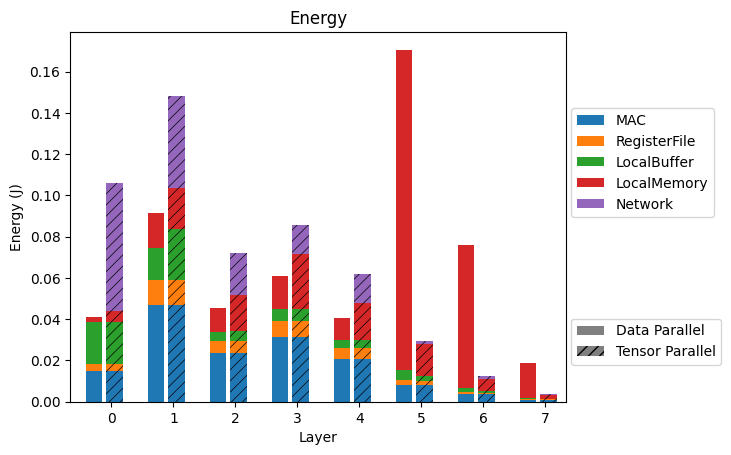

In [79]:
def plot_clustered_stacked(dfall, labels=None, title="Title", xlabel="xlabel", ylabel="ylabel", H="///", **kwargs):
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall:
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)

    h,l = axe.get_legend_handles_labels()
    for i in range(0, n_df * n_col, n_col):
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches:
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col))
                rect.set_hatch_linewidth(0.5)
                rect.set_width(0.8 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    axe.set_xlabel(xlabel)
    axe.set_ylabel(ylabel)

    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


df1 = pd.DataFrame(np.zeros((8, 5)),
                   index=["0", "1", "2", "3", "4", "5", "6", "7"],
                   columns=["MAC", "RegisterFile", "LocalBuffer", "LocalMemory", "Network"])

df2 = pd.DataFrame(np.zeros((8, 5)),
                   index=["0", "1", "2", "3", "4", "5", "6", "7"],
                   columns=["MAC", "RegisterFile", "LocalBuffer", "LocalMemory", "Network"])

for problem in LAYERS:
    result = get_result_data_parallel(problem, 16, 16)
    for component, energy in result['per_component_energy'].items():
        df1.loc[problem[-6], component] = energy

for problem in LAYERS:
    result = get_result_tensor_parallel(problem, 16, 16)
    for component, energy in result['per_component_energy'].items():
        df2.loc[problem[-6], component] = energy

plot_clustered_stacked([df1, df2],["Data Parallel", "Tensor Parallel"], "Energy", "Layer", "Energy (J)")

In [ ]:
total_energy_dp = np.array([320536.32, 326133.50999999995, 359342.34, 421380.81, 544487.17])
total_latency_dp = np.array([1828792320, 919068672, 457198080, 228599040, 114299520])
conv_energy_dp = np.array([40836.68, 40839.65, 40845.6, 40857.5, 40881.29])
conv_latency_dp = np.array([1499238400, 749619200, 374809600, 187404800, 93702400])
fc_energy_dp = np.array([3084.45, 3691.62, 5761.71, 10067.64, 18576.15])
fc_latency_dp = np.array([1638400, 819200, 409600, 204800, 102400])

total_energy_tp = np.array([320536.32, 320649.1754816, 332405.39288959996, 379613.1234848, 519341.167792])
total_latency_tp = np.array([1828792320, 914396160, 457984512, 228803840, 119561472])
conv_energy_tp = np.array([40836.68, 41562.58064, 44560.69384, 56742.22792, 105846.4368])
conv_latency_tp = np.array([1499238400, 749619200, 374809600, 187404800, 93702400])
fc_energy_tp = np.array([3084.45, 2947.9624000000003, 3166.6344, 3011.5972, 3752.578])
fc_latency_tp = np.array([1638400, 819200, 409600, 409600, 114688])

In [ ]:
plt.plot(NUM_GPUS, total_energy_dp, label="DP")
plt.plot(NUM_GPUS, total_energy_tp, label="TP")
plt.xlabel("Number of GPUs")
plt.ylabel("Energy (uJ)")
plt.legend()
plt.title("AlexNet")

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
# fig.suptitle('Plots')
# ax1.plot(NUM_GPUS, total_energy_dp)
# ax1.plot(NUM_GPUS, total_energy_tp)
# ax2.plot(NUM_GPUS, total_latency_dp)
# ax2.plot(NUM_GPUS, total_latency_tp)

# ax3.plot(NUM_GPUS, conv_energy_dp)
# ax3.plot(NUM_GPUS, conv_energy_tp)
# ax4.plot(NUM_GPUS, conv_latency_dp)
# ax4.plot(NUM_GPUS, conv_latency_tp)

# ax5.plot(NUM_GPUS, fc_energy_dp)
# ax5.plot(NUM_GPUS, fc_energy_tp)
# ax6.plot(NUM_GPUS, fc_latency_dp)
# ax6.plot(NUM_GPUS, fc_latency_tp)

# for ax in fig.get_axes():
#     ax.label_outer()

In [ ]:
plt.plot(NUM_GPUS, total_latency_dp, label="DP")
plt.plot(NUM_GPUS, total_latency_tp, label="TP")
plt.xlabel("Number of GPUs")
plt.ylabel("Latency (cycles)")
plt.legend()
plt.title("AlexNet")

In [ ]:
plt.plot(NUM_GPUS, conv_energy_dp, label="DP")
plt.plot(NUM_GPUS, conv_energy_tp, label="TP")
plt.xlabel("Number of GPUs")
plt.ylabel("Energy (uJ)")
plt.legend()
plt.title("CONV")

In [ ]:
plt.plot(NUM_GPUS, fc_energy_dp, label="DP")
plt.plot(NUM_GPUS, fc_energy_tp, label="TP")
plt.xlabel("Number of GPUs")
plt.ylabel("Energy (uJ)")
plt.legend()
plt.title("FC")